In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re


In [2]:
flight_data = pd.read_csv('flight_data_kiwi_allsnaps_clean.csv') #קריאת הנתונים


In [3]:
# Define airport to city mappings
airport_to_city = {
    'BVA': 'Paris', 'ORY': 'Paris', 'PAR': 'Paris', 'CDG': 'Paris',
    'CIA': 'Rome', 'FCO': 'Rome',
    'SEN': 'London', 'LCY': 'London', 'STN': 'London', 'LHR': 'London', 'LGW': 'London', 'LTN': 'London'
}

# Airports to cities
flight_data['From City'] = flight_data['From'].map(airport_to_city)
flight_data['Landing City'] = flight_data['Landing'].map(airport_to_city)

In [4]:
# Function to convert duration to minutes
def convert_duration_to_minutes(duration):
    hours, minutes = 0, 0
    # Extract hours and minutes using regex
    match = re.match(r'(\d+)h (\d+)m', duration)
    if match:
        hours, minutes = int(match.group(1)), int(match.group(2))
    else:
        match = re.match(r'(\d+)h', duration)
        if match:
            hours = int(match.group(1))
        match = re.match(r'(\d+)m', duration)
        if match:
            minutes = int(match.group(1))
    return hours * 60 + minutes


In [5]:
# Clean the 'Price' column: Remove any non-digit characters and convert to float
flight_data['Price'] = flight_data['Price'].str.extract('(\d+)', expand=False).astype(float)

# Check if there are any null values in the 'Price' column
print(flight_data['Price'].isnull().sum())

0


<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\orian\AppData\Local\Temp\ipykernel_6848\3994876472.py:2: SyntaxWarning: invalid escape sequence '\d'
  flight_data['Price'] = flight_data['Price'].str.extract('(\d+)', expand=False).astype(float)


In [6]:
# Function to remove outliers for each combination of source and destination city
# Removing outliers using the Tukey (1.5IQR) method 
def remove_outliers(df):
    Q1 = df['Price'].quantile(0.25)
    Q3 = df['Price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

# Appling the function for each city pair
flight_data = flight_data.groupby(['From City', 'Landing City']).apply(remove_outliers).reset_index(drop=True)

C:\Users\orian\AppData\Local\Temp\ipykernel_6848\2699558146.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  flight_data = flight_data.groupby(['From City', 'Landing City']).apply(remove_outliers).reset_index(drop=True)


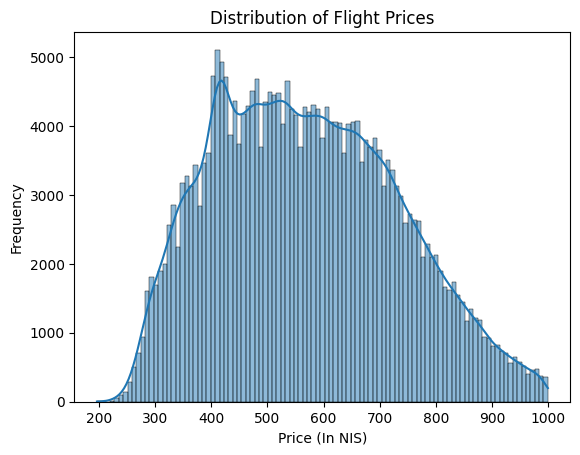

In [7]:
#1 התפלגות מחירי הטיסות בכללי
sns.histplot(flight_data['Price'], kde=True)
plt.title('Distribution of Flight Prices')
plt.xlabel('Price (In NIS)')
plt.ylabel('Frequency')
plt.show()


Conclusions from the graph:

1. **Price distribution with a peak around 400 NIS**: Most prices are in the range of 300 to 500 NIS, with a peak around 400 NIS.
2. **Long tail distribution**: There is a decrease in the availability of prices above 600 NIS, with a less dense distribution.
3. **High variance**: The graph shows significant variability in prices, especially in the higher ranges.

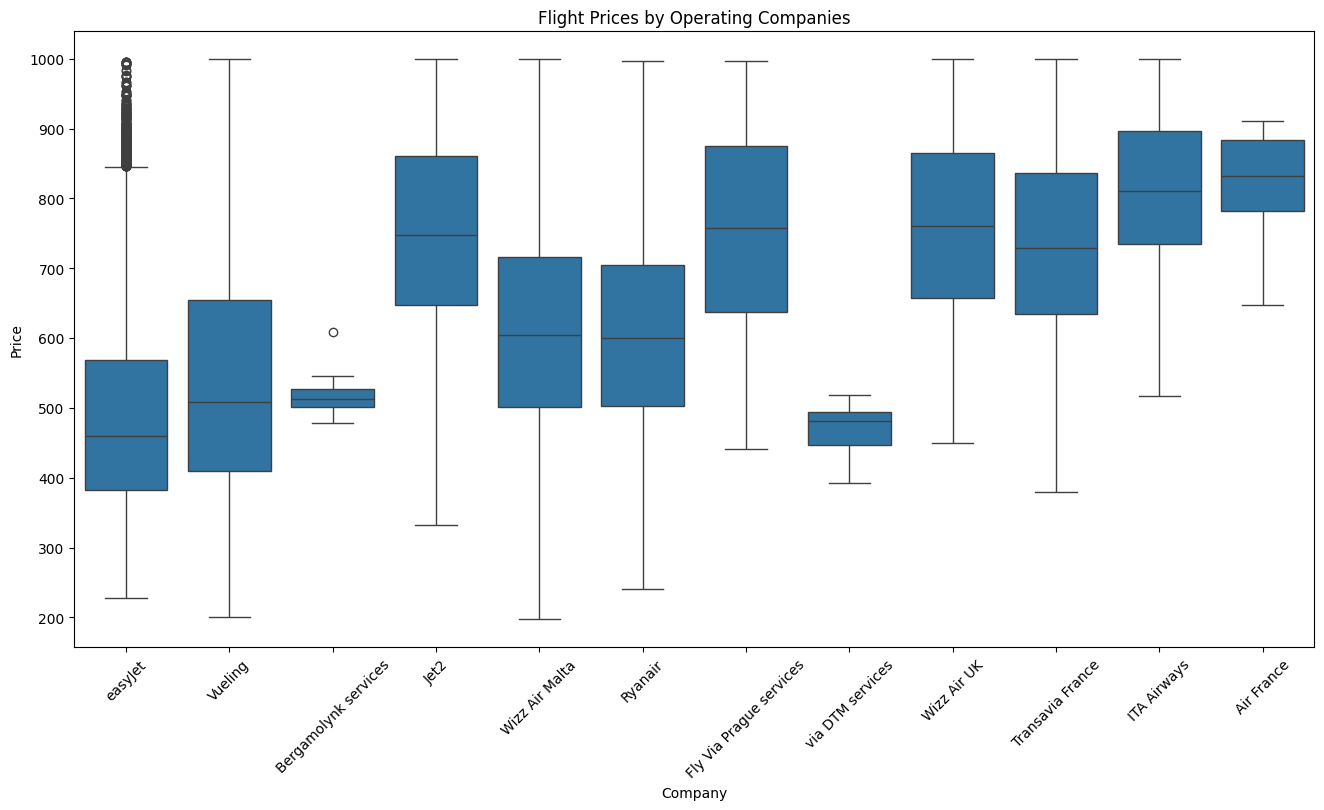

In [8]:
#2 מחירי הטיסות בהינתן חברות מפעילות
plt.figure(figsize=(16, 8))
sns.boxplot(x='Dep Company', y='Price', data=flight_data)
plt.xticks(rotation=45)
plt.title('Flight Prices by Operating Companies')
plt.xlabel('Company')
plt.ylabel('Price')
plt.show()

Conclusions from the graph:

1. **Low-cost airlines**: easyJet and Vueling show lower prices with a narrow range.
2. **Higher-priced airlines**: Air France and ITA Airways have higher prices with a wider range.
3. **Price distribution**: Most airlines show a similar price range, but there are outliers with exceptionally expensive flights.

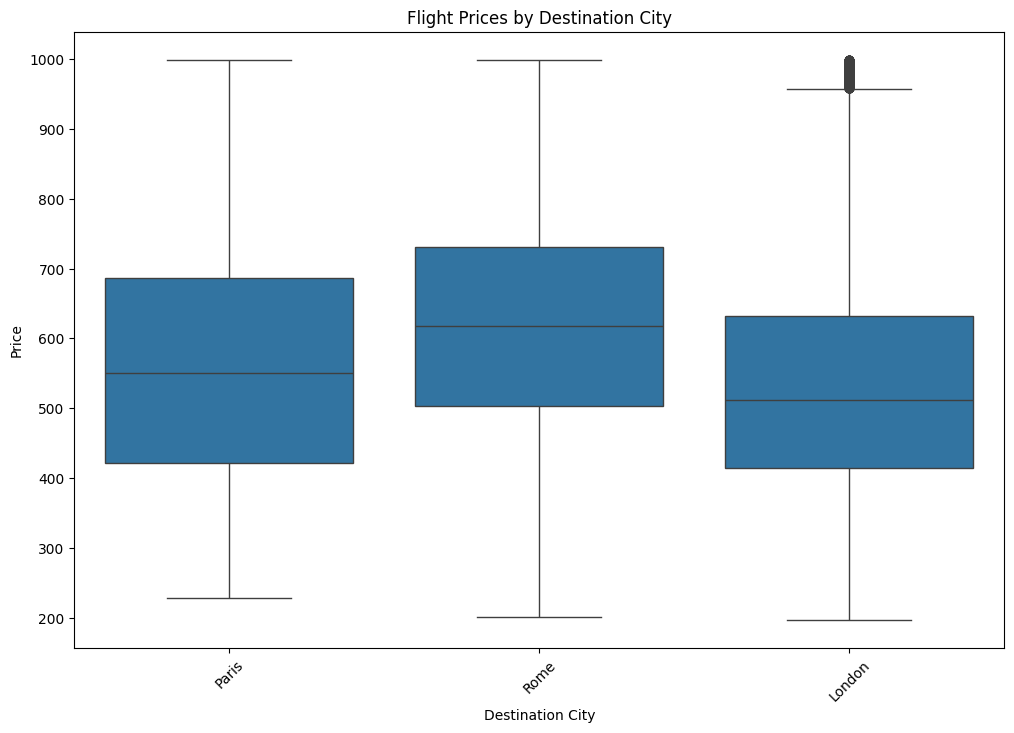

In [9]:
#3.1 *מחירי הטיסות על פי יעדים שונים, עשיתי בהמשך עוד אחד *לפי כל מקור
plt.figure(figsize=(12, 8))
sns.boxplot(x='Landing City', y='Price', data=flight_data)
plt.title('Flight Prices by Destination City')
plt.xlabel('Destination City')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

Conclusions from the graph:

1. **Similar prices**: Prices for Paris and Rome are similar, with a median around 500-600 NIS.
2. **London** shows higher prices, with a median around 700 NIS.
3. **Wider distribution in London**: London has a wider price range, including some very expensive flights.

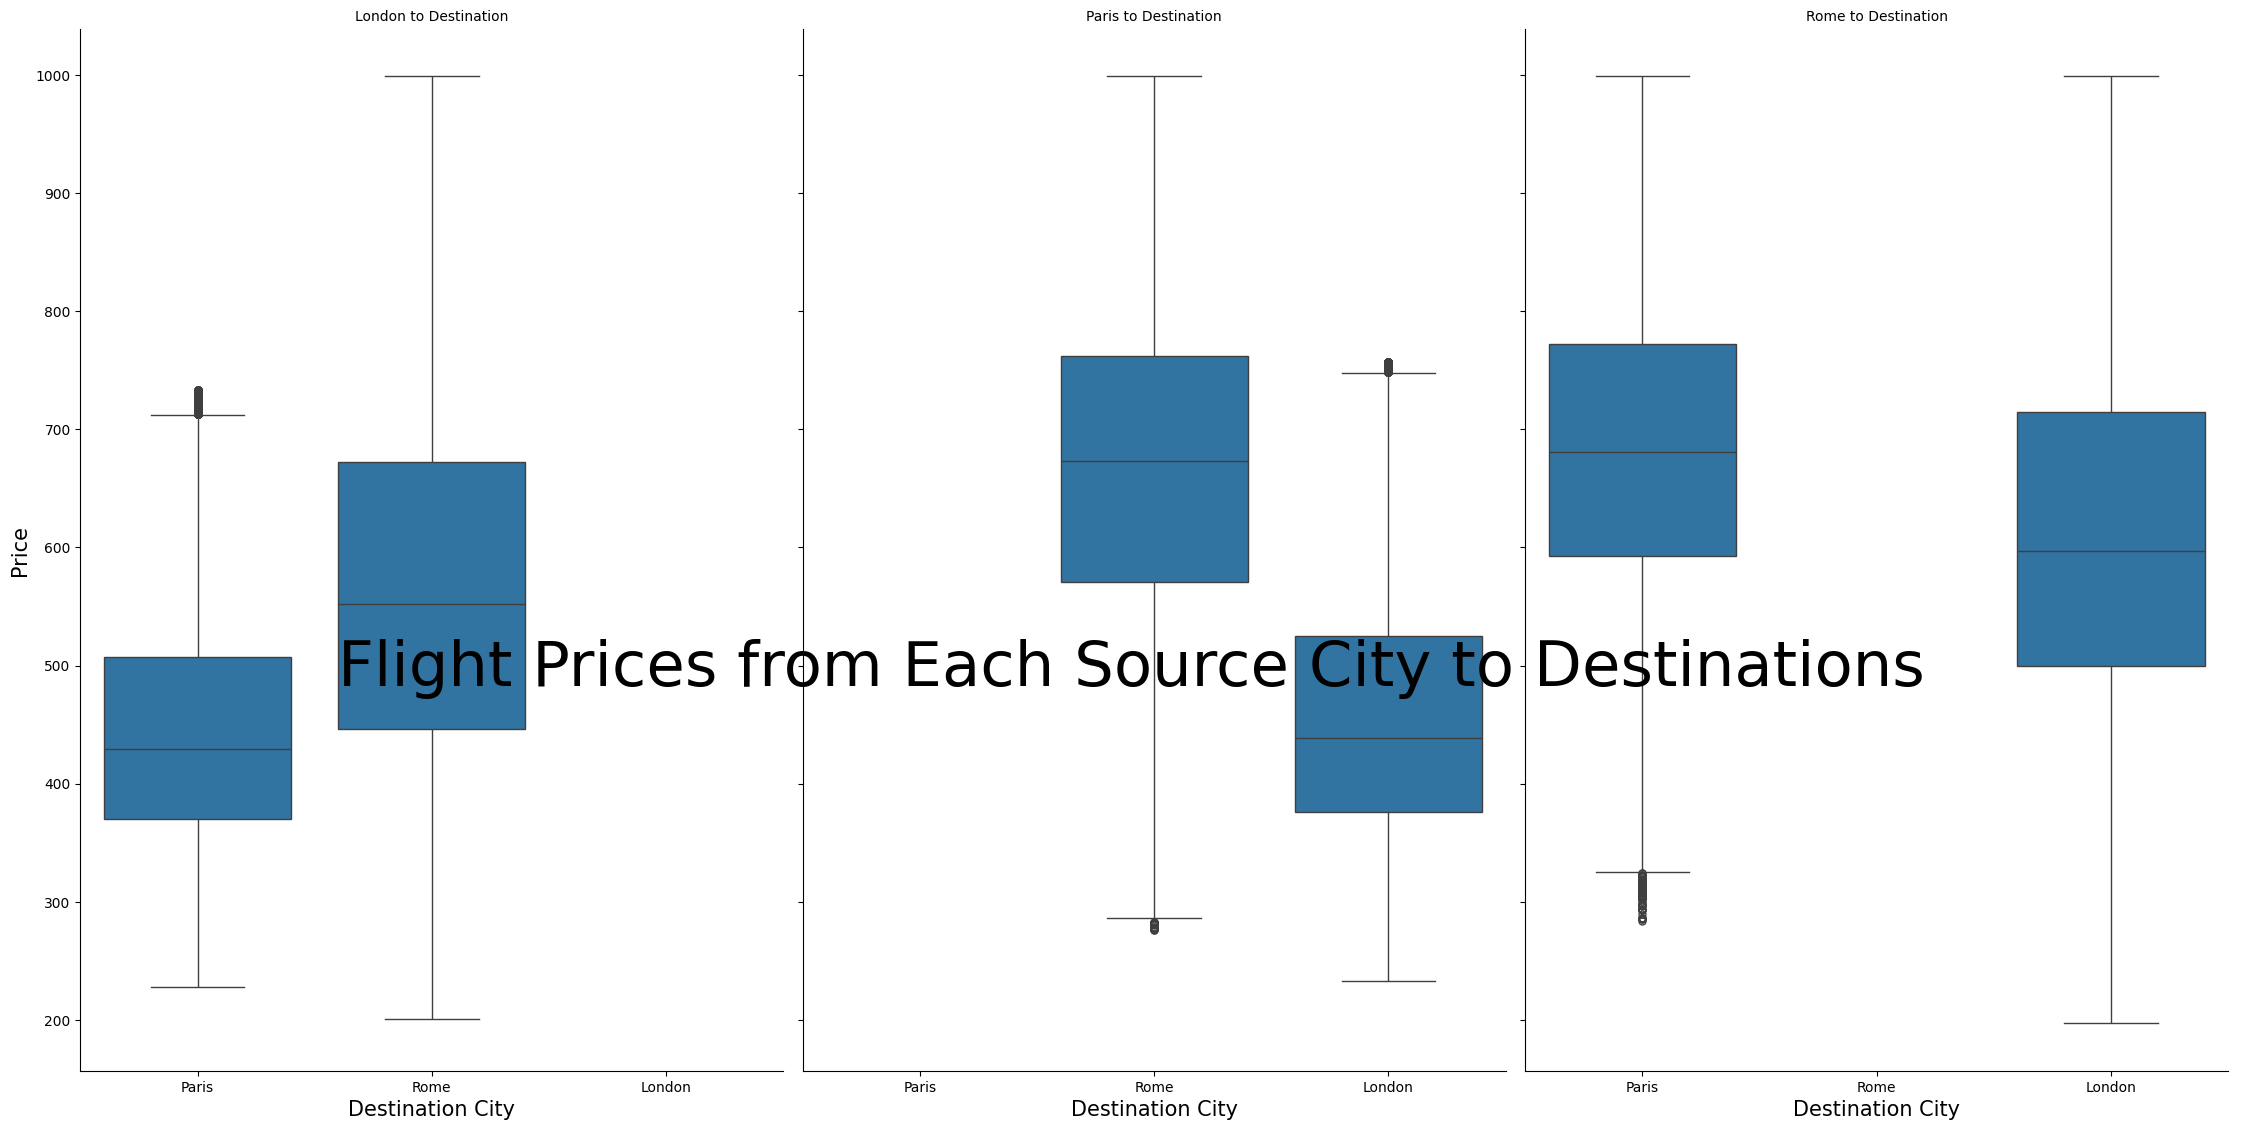

In [10]:
#3.2 מחירי הטיסות על פי יעדים שונים לפי כל מקור!
relevant_data = flight_data[
    (flight_data['From City'].isin(['Paris', 'Rome', 'London'])) & 
    (flight_data['Landing City'].isin(['Paris', 'Rome', 'London']))
]
# Plotting the distribution of flight prices for each route from every source city
g = sns.catplot(
    x='Landing City', 
    y='Price', 
    col='From City', 
    data=relevant_data, 
    kind='box',
    height=5, 
    aspect=1.5,
    col_wrap=3 ,
)
g.set_titles("{col_name} to Destination")
g.set_axis_labels("Destination City", "Price",fontsize=15)
g.set_xticklabels()
plt.subplots_adjust(top=2.2)
g.fig.suptitle('Flight Prices from Each Source City to Destinations',fontsize=45)
plt.show()


Conclusions from the graph:

1. **Lower prices for flights from London**: Flights from London to different destinations show lower prices, especially to Paris.
2. **Higher prices for flights from Rome**: Flights from Rome show higher prices, especially to London.
3. **Similar distribution**: Prices for flights from Paris and London are similar in terms of price range and median.

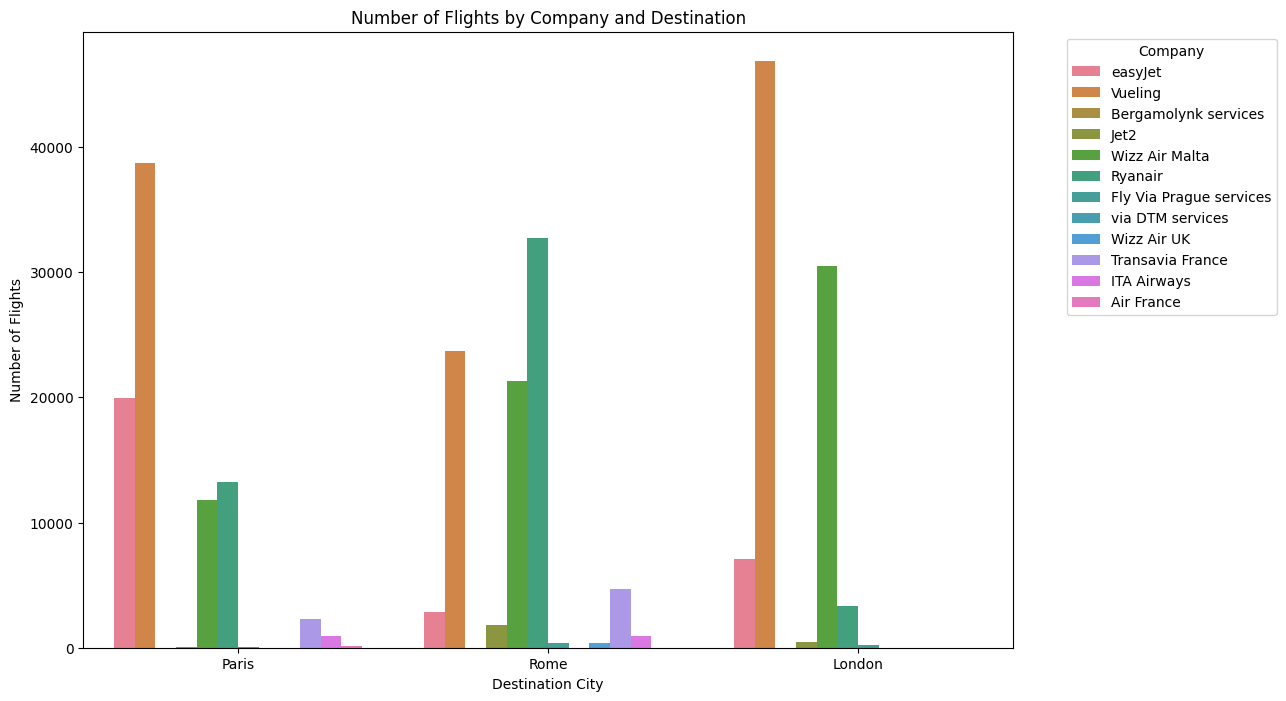

In [11]:
#4 התפלגות הטיסות של חברות השונות על הטיסות פר יעד
plt.figure(figsize=(12, 8))
sns.countplot(x='Landing City', hue='Dep Company', data=flight_data)
plt.title('Number of Flights by Company and Destination')
plt.xlabel('Destination City')
plt.ylabel('Number of Flights')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks()
plt.show()


Conclusions from the graph:

1. **Paris** shows the highest number of flights, especially with **Vueling** and **easyJet**.
2. **Rome** has fewer flights, with **Wizz Air Malta** and **Jet2** leading.
3. **London** shows the second-highest number of flights, primarily with **Ryanair** and **Wizz Air Malta**.

In [12]:
# Clean and convert 'Stops' to numeric by using our function from earlier but this time on "flight_data".
flight_data['Stops'] = pd.to_numeric(flight_data['Stops'], errors='coerce')

# Filtering flights with 0,1 or 2 stops:
relevant_flights = flight_data[flight_data['Stops'].isin([0, 1, 2])]

# Applying the conversion function we used earlier to the 'Dep Duration' column of relevant_flights
relevant_flights['Dep Duration Minutes'] = relevant_flights['Dep Duration'].apply(lambda x: convert_duration_to_minutes(str(x)))

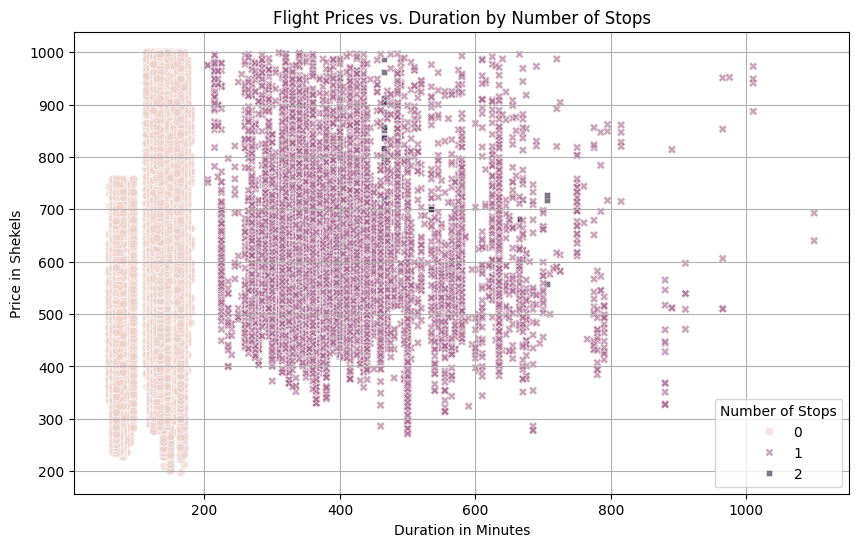

In [13]:
#5 התפלגות זמני קונקשן וזמני טיסות בין היעדים השונים
# 0,זמני קונקשן - 1,2
plt.figure(figsize=(10, 6))
sns.scatterplot(data=relevant_flights, x='Dep Duration Minutes', y='Price', hue='Stops', style='Stops', alpha=0.6)
plt.title('Flight Prices vs. Duration by Number of Stops')
plt.xlabel('Duration in Minutes')
plt.ylabel('Price in Shekels')
plt.legend(title='Number of Stops')
plt.grid(True)
plt.show()

Conclusions from the graph:

1. **Lower prices with fewer stops**: Non-stop flights (0 Stops) show lower prices, especially for shorter durations.
2. **Wider distribution with 1 or 2 stops**: Flights with 1 or 2 stops show a wider price distribution, especially for longer flights.
3. **Longer flight duration with more stops**: Flights with 1 or 2 stops tend to be longer, but they are not necessarily more expensive.

In [14]:
#מסקנות:
#
# 1.                   נראה שיש קשר בן זמני טיסה ארוכים מהרגיל למחירם המוזל יותר (שכנראה עקב כך)
#
# 2.                                       נראה כי עד ה300 דקות יש התפלגות נורמאלית המזכירה פעמון
#                      כי ככל הנראה- בטווח של עד 5 שעות בטיסות ישירות- ככל שהטיסה לוקחת יותר זמן
#            .כנראה שבגלל שהיעד יותר רחוק ולכן המחיר עולה לפי עלויות טכניות כמו דלק ומשאבי אנוש
print("                                                                                               :מסקנות\n")
print("                נראה שמחירי טיסות עם 2 עצירות תמיד גבוה מהרגיל (נמצא רק בחלק האמצע עליון של הגרף)\n")
print("                                         -נראה כי בסביבות ה400 דקות יש התפלגות נורמאלית המזכירה פעמון")
print("     ..כי לפי הנראה- בטווח של עד 7 שעות ב*טיסות לא ישירות*- ככל שהטיסה לוקחת יותר זמן היא יותר יקרה")
print("                 .כנראה שבגלל שהיעד יותר רחוק ולכן המחיר עולה לפי עלויות טכניות כמו דלק ומשאבי אנוש")

                                                                                               :מסקנות

                נראה שמחירי טיסות עם 2 עצירות תמיד גבוה מהרגיל (נמצא רק בחלק האמצע עליון של הגרף)

                                         -נראה כי בסביבות ה400 דקות יש התפלגות נורמאלית המזכירה פעמון
     ..כי לפי הנראה- בטווח של עד 7 שעות ב*טיסות לא ישירות*- ככל שהטיסה לוקחת יותר זמן היא יותר יקרה
                 .כנראה שבגלל שהיעד יותר רחוק ולכן המחיר עולה לפי עלויות טכניות כמו דלק ומשאבי אנוש


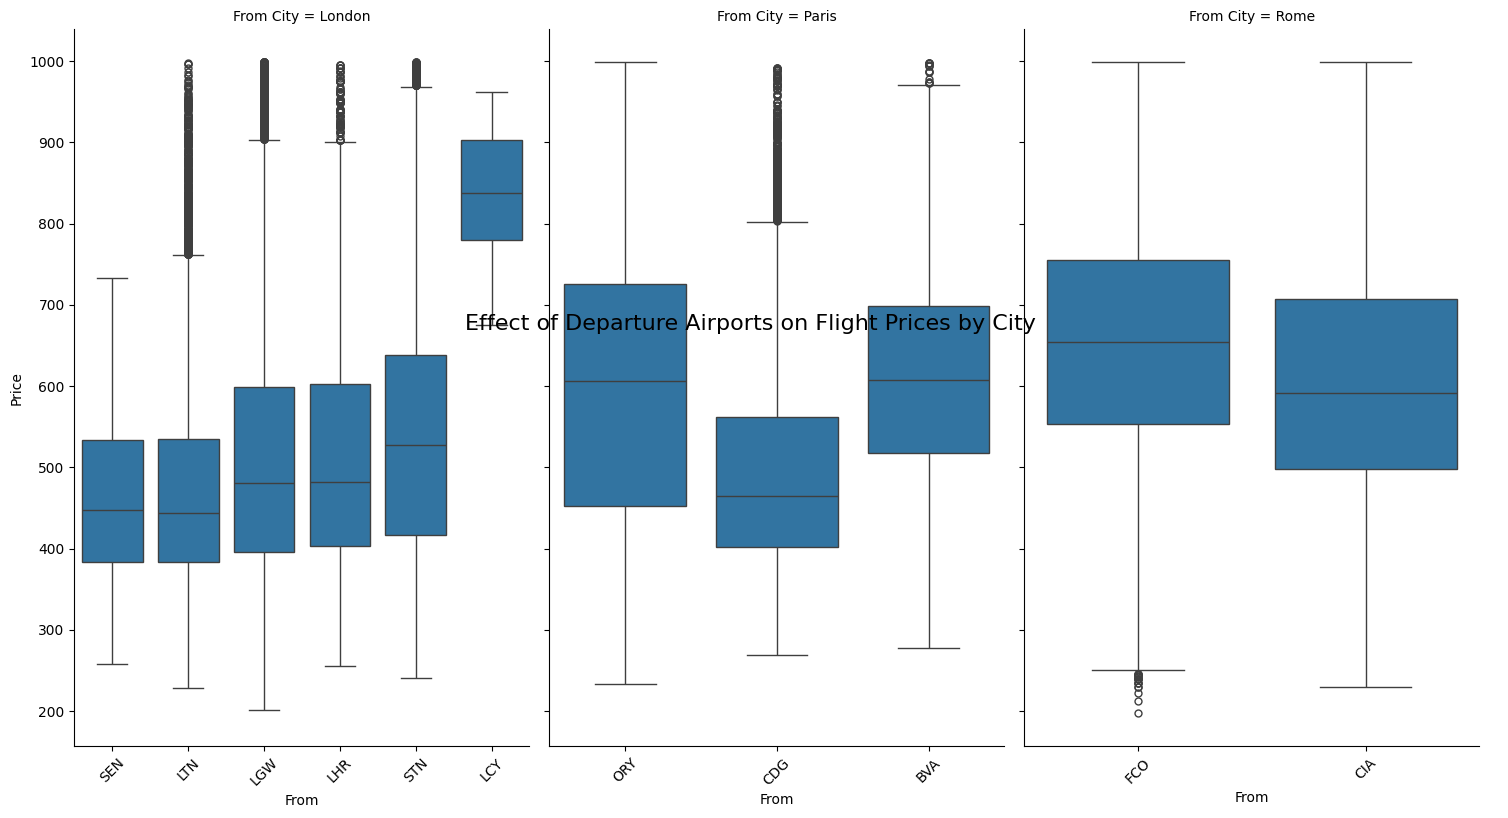

In [15]:
#6 השפעת שדות התעופה בכל עיר על המחירים של הטיסות בין היעדים
g = sns.catplot(
    x='From',
    y='Price',
    col='From City',
    data=flight_data,
    kind='box',
    col_wrap=3,
    height=5,
    aspect=1,
    sharex=False  # ככה שזה יבדיל ויצמיד לכל עיר את השדות תעופה הרלוונטים לו
)

# Rotate labels for readability
g.set_xticklabels(rotation=45)
g.fig.suptitle('Effect of Departure Airports on Flight Prices by City', fontsize=16)
plt.subplots_adjust(top=1.55)  # Move plots down to make space for the title
plt.show()

Conclusions from the graph:

1. **London**: There is significant price variation between airports. **LHR** shows particularly high prices, while **SEN** and **STN** show lower prices.
2. **Paris**: There is less price variation, with airports **CDG** and **ORY** showing similar prices, and **BVA** displaying lower prices.
3. **Rome**: Flights from **FCO** show higher prices, especially compared to **CIA**, where the prices are lower.

In [16]:
# מטריצת מתאמים בין משתנים מספריים
plt.figure(figsize=(10,6))
sns.heatmap(relevant_flights.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

ValueError: could not convert string to float: '2025-03-02'

<Figure size 1000x600 with 0 Axes>

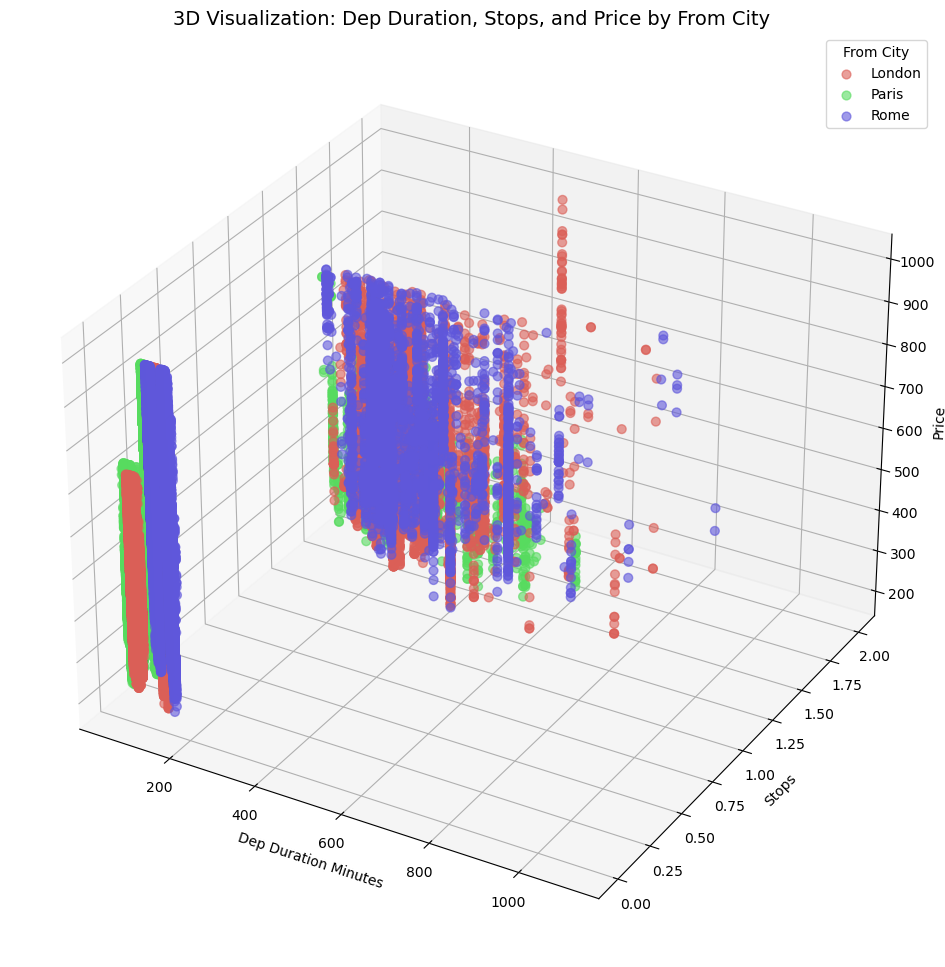

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# Create a figure and a 3D axis
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# We'll color-code by the departure city
cities = relevant_flights['From City'].unique()
colors = sns.color_palette('hls', len(cities))

# Plot each city in a different color
for city, color in zip(cities, colors):
    subset = relevant_flights[relevant_flights['From City'] == city]
    ax.scatter(
        subset['Dep Duration Minutes'],
        subset['Stops'],
        subset['Price'],
        color=color,
        label=city,
        alpha=0.6,
        s=40
    )

# Set axis labels
ax.set_xlabel('Dep Duration Minutes')
ax.set_ylabel('Stops')
ax.set_zlabel('Price')

# Add a legend
ax.legend(title='From City')

# Set a title
plt.title('3D Visualization: Dep Duration, Stops, and Price by From City', fontsize=14)

plt.show()

Conclusions from the graph:

1. **London** (red) shows flights with shorter durations (under 300 minutes), especially with fewer stops.
2. **Rome** (blue) shows longer flights, particularly those with more stops.
3. **Paris** (green) has a distribution similar to London, but also includes longer flights with more stops.
4. **Prices**: Prices are higher for longer flights or those with more stops, but not necessarily based on the departure city.

In [ ]:
# שמירת הנתונים לאחר עיבוד
flight_data.to_csv('flight_data_Kiwi_Allsnaps_AfterStep2_Clean.csv', index=False)
print(f"flight_data_Kiwi_Allsnaps_AfterStep2_Clean.csv")
print(f"Done")

flight_data_Kiwi_Allsnaps_AfterStep2_Clean.csv
Done
